# Import packages

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

# Preprocessing

In [104]:
dataframe  = pd.read_csv('data/term-deposit-marketing-2020.csv')
dataframe['y'] = dataframe.y.replace(to_replace=['no', 'yes'], value=[0, 1])
dataframe

age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
39995   53    technician   married   tertiary      no      395      no   no   
39996   30    management    single   tertiary      no     3340      no   no   
39997   54         admin  divorced  secondary      no      200      no   no   
39998   34    management   married   tertiary      no     1047      no   no   
39999   38    technician   married  secondary      no     1442     yes   no   

        contact  day month  duration  campaign  y  
0       unknown    5   may       261         1  0  
1       unknown    5   may       151         1  0  
2       unknown    5   may        76         1  0  
3       unknown    5   may        92         1  0  
4       unknown    5   may       198         1  0  
...         ...  ...   ...       ...       ... ..  
39995  cellular    3   jun       107         1  0  
39996  cellular    3   jun       238         3  1  
39997  cellular    3   jun       170         1  1  
39998  cellular    3   jun       342         1  0  
39999  cellular    3   jun       113         1  0  

[40000 rows x 14 columns]

### Statistics

In [105]:
dataframe.describe().transpose()

count         mean          std     min    25%    50%     75%  \
age       40000.0    40.544600     9.641776    19.0   33.0   39.0    48.0   
balance   40000.0  1274.277550  2903.769716 -8019.0   54.0  407.0  1319.0   
day       40000.0    16.017225     8.278127     1.0    8.0   17.0    21.0   
duration  40000.0   254.824300   259.366498     0.0  100.0  175.0   313.0   
campaign  40000.0     2.882175     3.239051     1.0    1.0    2.0     3.0   
y         40000.0     0.072400     0.259152     0.0    0.0    0.0     0.0   

               max  
age           95.0  
balance   102127.0  
day           31.0  
duration    4918.0  
campaign      63.0  
y              1.0

## Analyze imbalance in the targets

In [106]:
neg, pos = np.bincount(dataframe['y'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Examples:
    Total: 40000
    Positive: 2896 (7.24% of total)



In [107]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 32000 samples for training and 8000 for validation


In [143]:
counts = np.bincount(train_dataframe['y'])

weight_for_0 = 1.0 / counts[0] * (np.sum(counts))/2.0
weight_for_1 = 1.0 / counts[1] * (np.sum(counts))/2.0

In [109]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("y")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [110]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=49>, 'job': <tf.Tensor: shape=(), dtype=string, numpy=b'technician'>, 'marital': <tf.Tensor: shape=(), dtype=string, numpy=b'divorced'>, 'education': <tf.Tensor: shape=(), dtype=string, numpy=b'secondary'>, 'default': <tf.Tensor: shape=(), dtype=string, numpy=b'no'>, 'balance': <tf.Tensor: shape=(), dtype=int64, numpy=790>, 'housing': <tf.Tensor: shape=(), dtype=string, numpy=b'yes'>, 'loan': <tf.Tensor: shape=(), dtype=string, numpy=b'no'>, 'contact': <tf.Tensor: shape=(), dtype=string, numpy=b'cellular'>, 'day': <tf.Tensor: shape=(), dtype=int64, numpy=7>, 'month': <tf.Tensor: shape=(), dtype=string, numpy=b'aug'>, 'duration': <tf.Tensor: shape=(), dtype=int64, numpy=324>, 'campaign': <tf.Tensor: shape=(), dtype=int64, numpy=3>}
Target: tf.Tensor(0, shape=(), dtype=int64)


In [111]:
train_ds = train_ds.batch(2000)
val_ds = val_ds.batch(2000)

### Feature preprocessing with Keras layers using one-hot encoding

In [112]:
def encode_numerical_feature(feature, name, dataset):
    normalizer = Normalization()

    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    normalizer.adapt(feature_ds)

    encoded_feature = normalizer(feature)
    return encoded_feature

def encode_string_categorical_feature(feature, name, dataset):
    index = StringLookup()

    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    index.adapt(feature_ds)

    encoded_feature = index(feature)

    encoder = CategoryEncoding(output_mode="binary")

    feature_ds = feature_ds.map(index)

    encoder.adapt(feature_ds)

    encoded_feature = encoder(encoded_feature)
    return encoded_feature

### Build a model

In [113]:
job = keras.Input(shape=(1,), name="job", dtype="string")
marital = keras.Input(shape=(1,), name="marital", dtype="string")
education = keras.Input(shape=(1,), name="education", dtype="string")
default = keras.Input(shape=(1,), name="default", dtype="string")
housing = keras.Input(shape=(1,), name="housing", dtype="string")
loan = keras.Input(shape=(1,), name="loan", dtype="string")
contact = keras.Input(shape=(1,), name="contact", dtype="string")
month = keras.Input(shape=(1,), name="month", dtype="string")

age = keras.Input(shape=(1,), name="age")
balance = keras.Input(shape=(1,), name="balance")
day = keras.Input(shape=(1,), name="day")
duration = keras.Input(shape=(1,), name="duration")
campaign = keras.Input(shape=(1,), name="campaign")

all_inputs = [
    job,
    marital,
    education,
    default,
    housing,
    loan,
    contact,
    month,
    age,
    balance,
    day,
    duration,
    campaign
]

job_encoded = encode_string_categorical_feature(job, "job", train_ds)
marital_encoded = encode_string_categorical_feature(marital, "marital", train_ds)
education_encoded = encode_string_categorical_feature(education, "education", train_ds)
default_encoded = encode_string_categorical_feature(default, "default", train_ds)
housing_encoded = encode_string_categorical_feature(housing, "housing", train_ds)
loan_encoded = encode_string_categorical_feature(loan, "loan", train_ds)
contact_encoded = encode_string_categorical_feature(contact, "contact", train_ds)
month_encoded = encode_string_categorical_feature(month, "month", train_ds)

age_encoded = encode_numerical_feature(age, "age", train_ds)
balance_encoded = encode_numerical_feature(balance, "balance", train_ds)
day_encoded = encode_numerical_feature(day, "day", train_ds)
duration_encoded = encode_numerical_feature(duration, "duration", train_ds)
campaign_encoded = encode_numerical_feature(campaign, "campaign", train_ds)

all_features = layers.concatenate(
    [
        job_encoded,
        marital_encoded,
        education_encoded,
        default_encoded,
        housing_encoded,
        loan_encoded,
        contact_encoded,
        month_encoded,
        age_encoded,
        balance_encoded,
        day_encoded,
        duration_encoded,
        campaign_encoded
    ]
)

In [136]:
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)

In [137]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name='auc'),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)

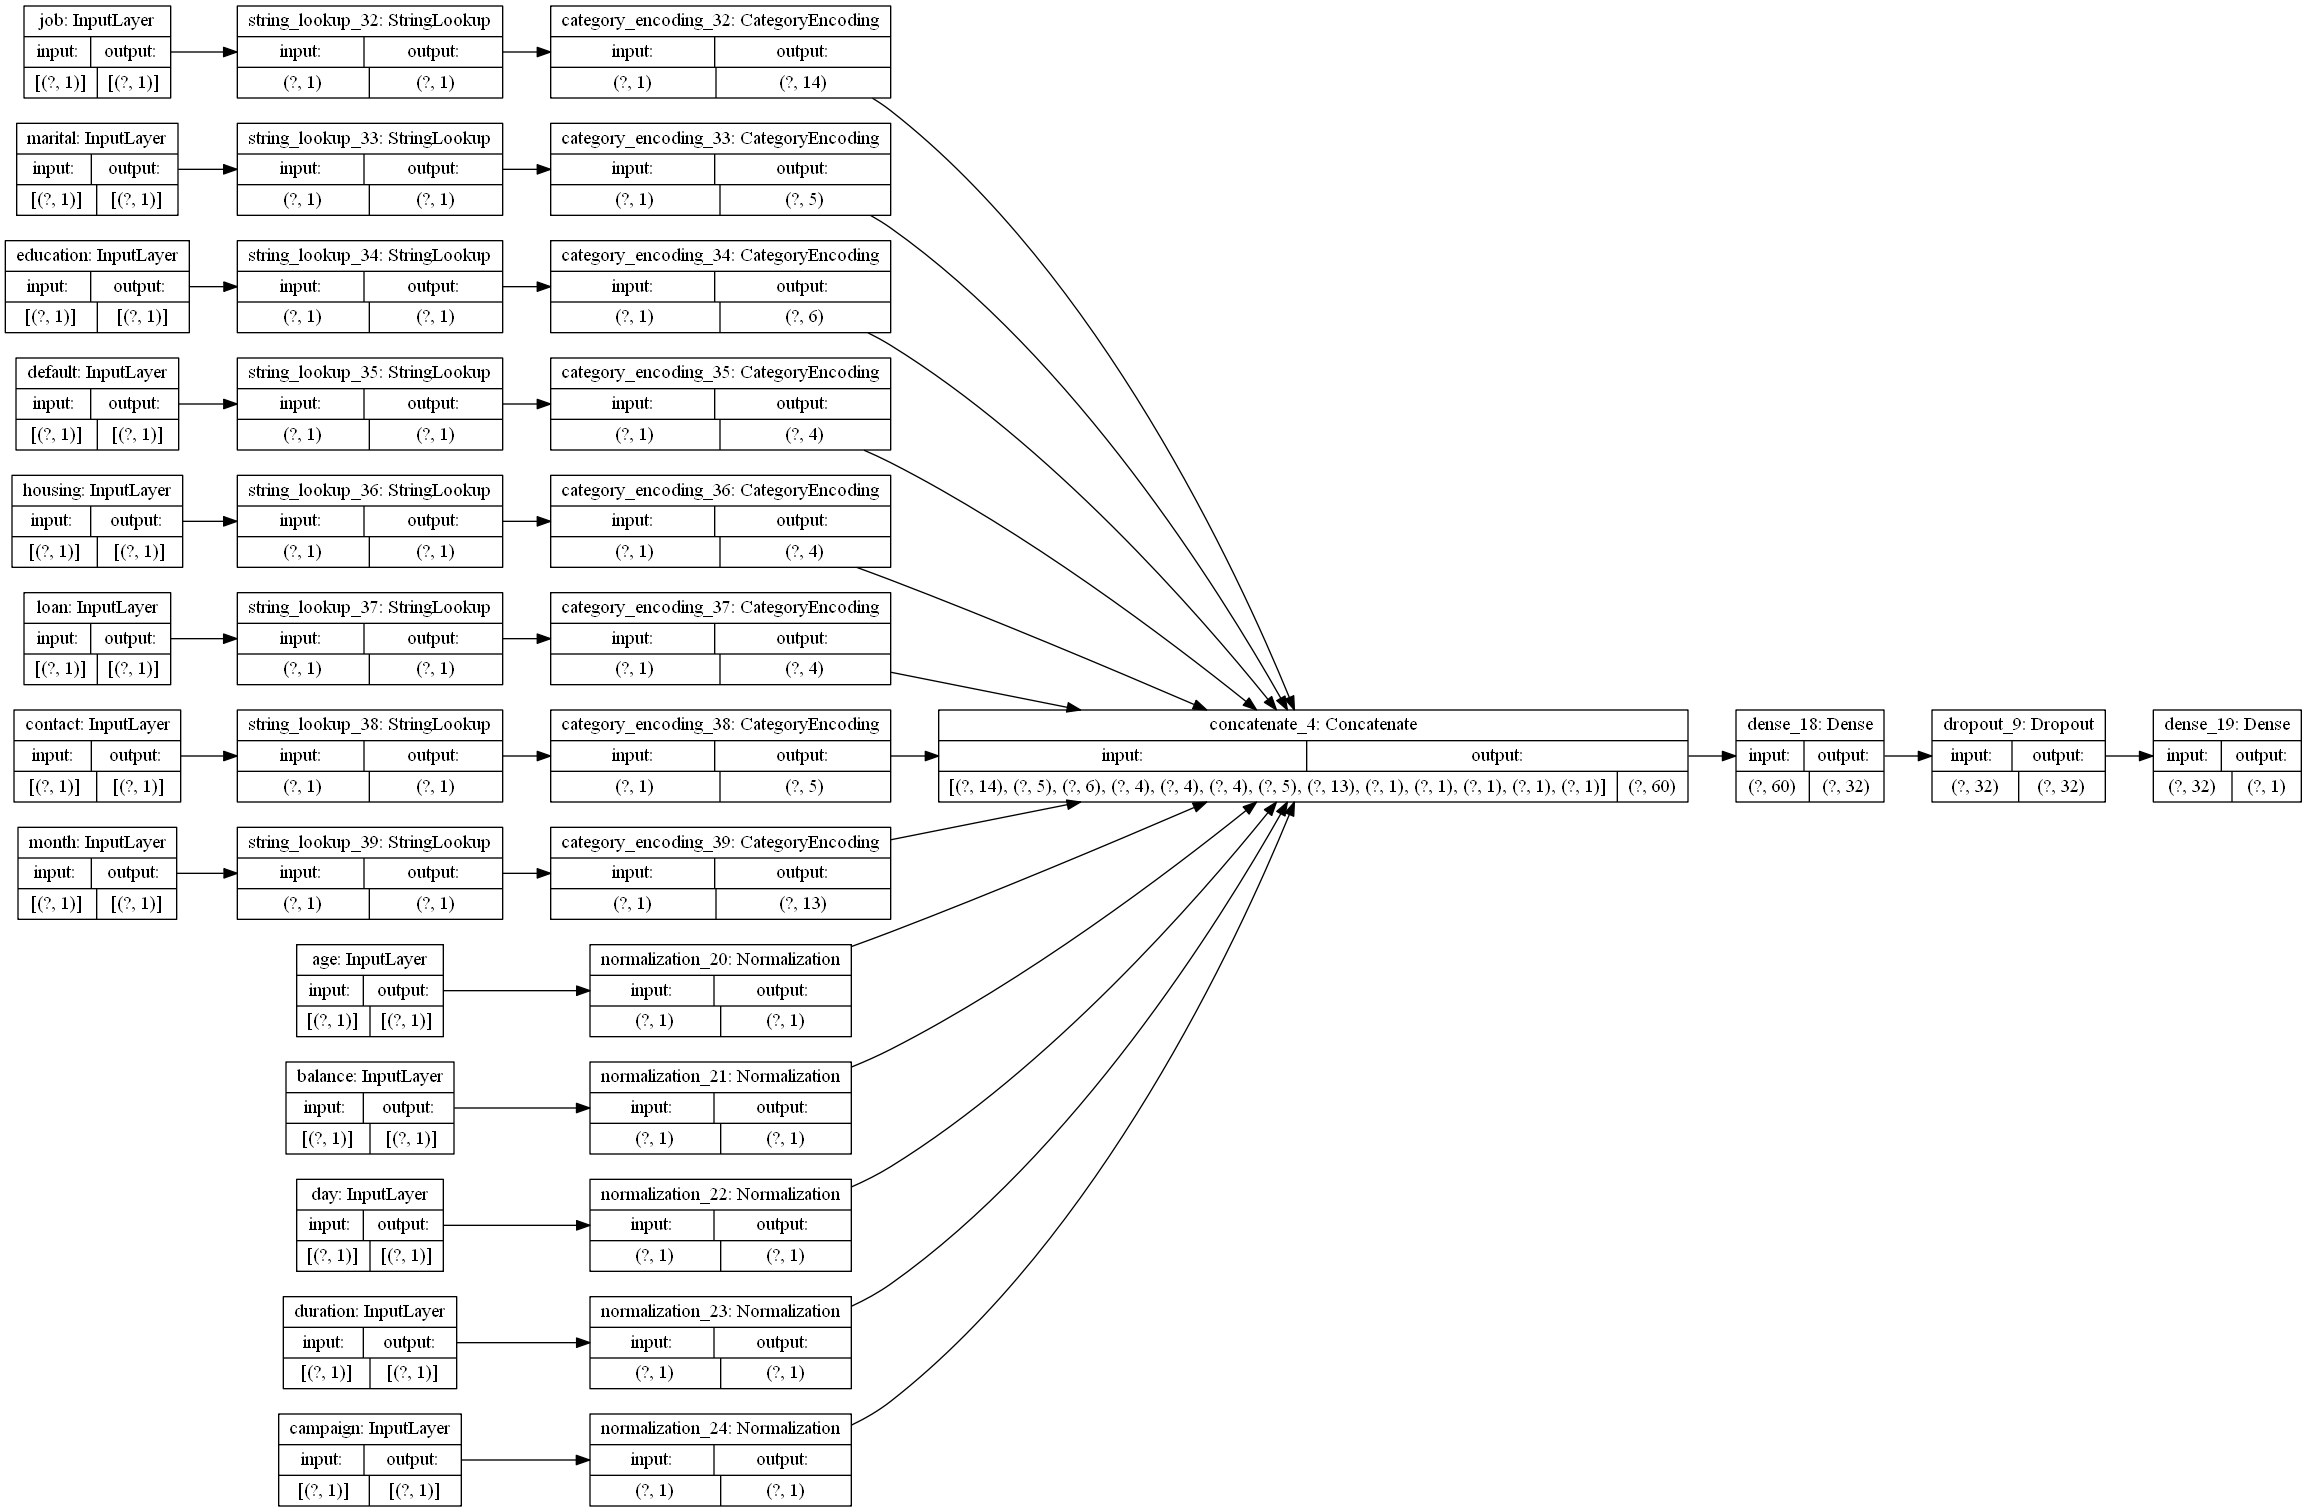

In [138]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

# Train the model

In [139]:
class_weight = {0: weight_for_0, 1: weight_for_1}

model.fit(
    train_ds,
    epochs=50,
    verbose=2,
    validation_data=val_ds,
    class_weight=class_weight,
)

Epoch 1/50
16/16 - 1s - loss: 0.5610 - fn: 660.0000 - fp: 8896.0000 - tn: 20816.0000 - tp: 1628.0000 - accuracy: 0.7014 - precision: 0.1547 - recall: 0.7115 - auc: 0.7834 - val_loss: 0.4249 - val_fn: 98.0000 - val_fp: 1158.0000 - val_tn: 6234.0000 - val_tp: 510.0000 - val_accuracy: 0.8430 - val_precision: 0.3058 - val_recall: 0.8388 - val_auc: 0.9155
Epoch 2/50
16/16 - 0s - loss: 0.4189 - fn: 432.0000 - fp: 4812.0000 - tn: 24900.0000 - tp: 1856.0000 - accuracy: 0.8361 - precision: 0.2783 - recall: 0.8112 - auc: 0.8988 - val_loss: 0.3919 - val_fn: 78.0000 - val_fp: 1092.0000 - val_tn: 6300.0000 - val_tp: 530.0000 - val_accuracy: 0.8537 - val_precision: 0.3268 - val_recall: 0.8717 - val_auc: 0.9314
Epoch 3/50
16/16 - 0s - loss: 0.3801 - fn: 342.0000 - fp: 4378.0000 - tn: 25334.0000 - tp: 1946.0000 - accuracy: 0.8525 - precision: 0.3077 - recall: 0.8505 - auc: 0.9180 - val_loss: 0.3622 - val_fn: 71.0000 - val_fp: 1111.0000 - val_tn: 6281.0000 - val_tp: 537.0000 - val_accuracy: 0.8522 - va

Epoch 25/50
16/16 - 0s - loss: 0.3121 - fn: 168.0000 - fp: 4935.0000 - tn: 24777.0000 - tp: 2120.0000 - accuracy: 0.8405 - precision: 0.3005 - recall: 0.9266 - auc: 0.9389 - val_loss: 0.3057 - val_fn: 48.0000 - val_fp: 1150.0000 - val_tn: 6242.0000 - val_tp: 560.0000 - val_accuracy: 0.8503 - val_precision: 0.3275 - val_recall: 0.9211 - val_auc: 0.9465
Epoch 26/50
16/16 - 0s - loss: 0.3090 - fn: 169.0000 - fp: 4989.0000 - tn: 24723.0000 - tp: 2119.0000 - accuracy: 0.8388 - precision: 0.2981 - recall: 0.9261 - auc: 0.9397 - val_loss: 0.3196 - val_fn: 40.0000 - val_fp: 1239.0000 - val_tn: 6153.0000 - val_tp: 568.0000 - val_accuracy: 0.8401 - val_precision: 0.3143 - val_recall: 0.9342 - val_auc: 0.9459
Epoch 27/50
16/16 - 0s - loss: 0.3096 - fn: 164.0000 - fp: 4996.0000 - tn: 24716.0000 - tp: 2124.0000 - accuracy: 0.8388 - precision: 0.2983 - recall: 0.9283 - auc: 0.9402 - val_loss: 0.3597 - val_fn: 33.0000 - val_fp: 1398.0000 - val_tn: 5994.0000 - val_tp: 575.0000 - val_accuracy: 0.8211 -

Epoch 49/50
16/16 - 0s - loss: 0.3054 - fn: 150.0000 - fp: 5056.0000 - tn: 24656.0000 - tp: 2138.0000 - accuracy: 0.8373 - precision: 0.2972 - recall: 0.9344 - auc: 0.9416 - val_loss: 0.3050 - val_fn: 46.0000 - val_fp: 1218.0000 - val_tn: 6174.0000 - val_tp: 562.0000 - val_accuracy: 0.8420 - val_precision: 0.3157 - val_recall: 0.9243 - val_auc: 0.9468
Epoch 50/50
16/16 - 0s - loss: 0.2969 - fn: 145.0000 - fp: 4841.0000 - tn: 24871.0000 - tp: 2143.0000 - accuracy: 0.8442 - precision: 0.3068 - recall: 0.9366 - auc: 0.9440 - val_loss: 0.2947 - val_fn: 57.0000 - val_fp: 1089.0000 - val_tn: 6303.0000 - val_tp: 551.0000 - val_accuracy: 0.8568 - val_precision: 0.3360 - val_recall: 0.9062 - val_auc: 0.9476


## Metrics

In [142]:
results = model.evaluate(val_ds, verbose=0)
for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)
print()

loss :  0.2946699857711792
fn :  57.0
fp :  1089.0
tn :  6303.0
tp :  551.0
accuracy :  0.8567500114440918
precision :  0.33597561717033386
recall :  0.90625
auc :  0.9476027488708496

